## Динамика логитов

In [1]:
!pip install datasets jaxtyping better_abc pillow wandb circuitsvis


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


#### Связи проекта

In [2]:
import sys
from pathlib import Path

In [3]:
path = "."
# for kaggle
path = "/kaggle/input/logitlens32/LogitLens/research/logits-dynamics/notebook"

ROOT = Path(path).absolute().parent.parent.parent

DATA = ROOT / "data"

In [4]:
if ROOT not in sys.path:
    sys.path.append(str(ROOT))

#### Импорт библиотек

In [5]:
import requests
import torch
from PIL import Image
import circuitsvis as cv
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from math import ceil
import json

import transformer_lens.utils as utils
from transformer_lens import HookedTransformer

from research.utils import get_data_images, plot_data, plot_data_attention, plot_images

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
E0000 00:00:1738603823.553654    1410 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


#### Логиты

Создаем модель

In [6]:
torch.set_grad_enabled(False)

In [7]:
device = utils.get_device()

In [8]:
model_name = "llava-hf/llava-1.5-7b-hf"
last_layer = 32

In [9]:
model = HookedTransformer.from_pretrained(model_name, device=device)

Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]
`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Loaded pretrained model llava-hf/llava-1.5-7b-hf into HookedTransformer


Загружаем изображения из датасета COCO

In [10]:
COCO = DATA / "coco_ann2017"
IMAGE_URL_FILE = COCO / "images_urls.json"

In [11]:
with open(IMAGE_URL_FILE, mode="r") as file:
    dict_images = json.load(file)

images = [Image.open(requests.get(url, stream=True).raw) for url in dict_images["urls"]]
class_images = dict_images["labels"]
prompt = "USER: <image>\nWhat is shown in the picture? ASSISTANT: The picture shows a"

Отобразим изображения

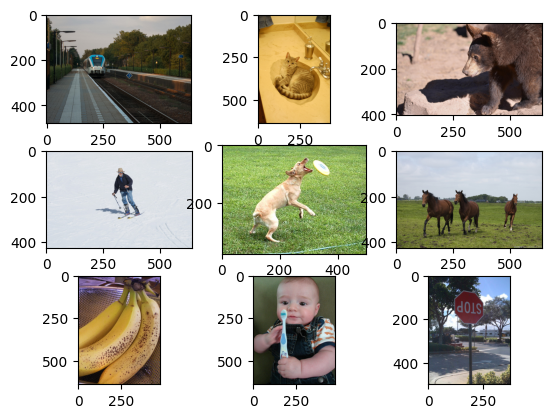

In [12]:
plot_images(images)

Соберем данные для каждого из изображений: токены, вероятность, энтропия, косинусное расстояние между последним слоем и промежуточными слоями модели и внимание.

In [13]:
data, data_attention = get_data_images(model, class_images, prompt, images, last_layer)

/kaggle/input/logitlens32/LogitLens/research/utils/get_data.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(model_logits)
/kaggle/input/logitlens32/LogitLens/research/utils/get_data.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  :].T).item() / torch.linalg.norm(


График зависимости вероятности предсказания правильного токена от номера слоя.

/usr/local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24184 (\N{CJK UNIFIED IDEOGRAPH-5E78}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24184 (\N{CJK UNIFIED IDEOGRAPH-5E78}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


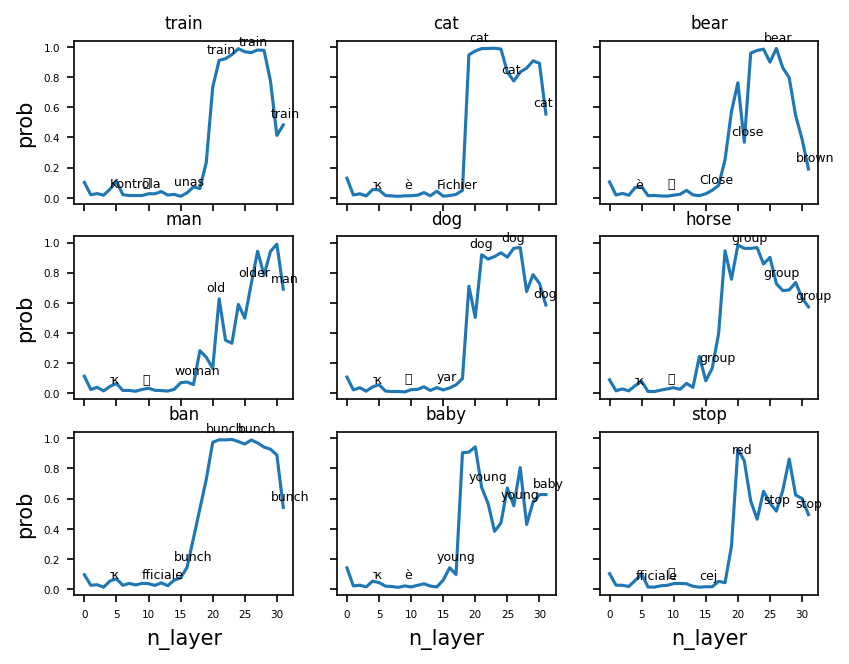

In [14]:
plot_data(data, class_images, data_id=1, xlabel='n_layer', ylabel='prob')

График зависимости энтропии от номера слоя.

Энтропия можно считать характеристикой уверенности модели в ответе.

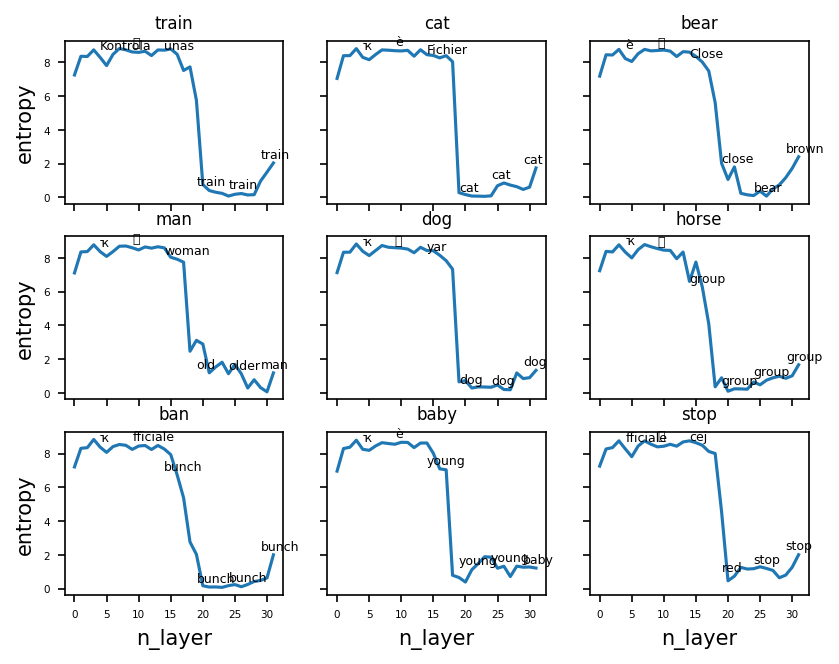

In [15]:
plot_data(data, class_images, data_id=2, dy=0.3, xlabel='n_layer', ylabel='entropy')

График зависимости косинусное расстояние между последним слоем и промежуточными слоями модели от номера слоя.

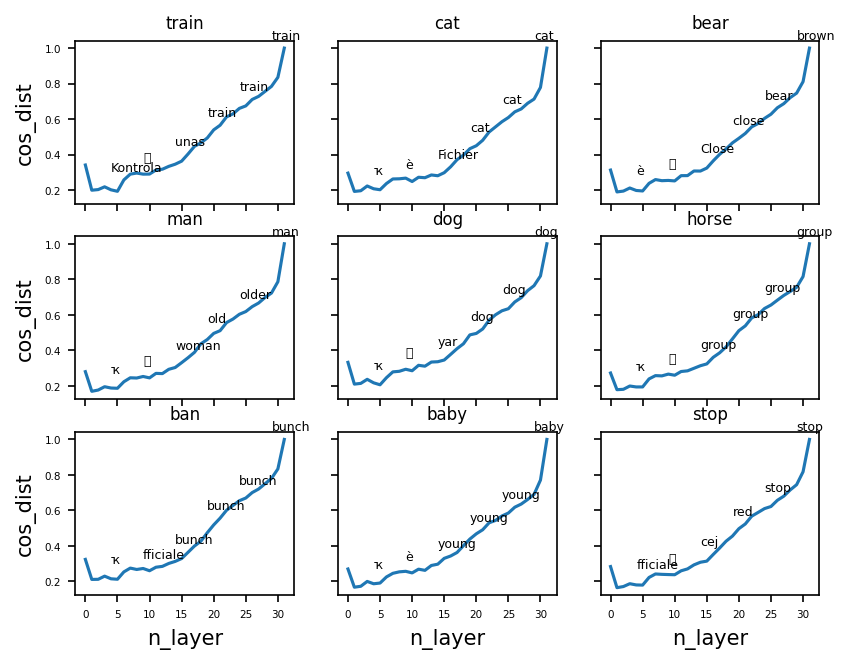

In [16]:
plot_data(data, class_images, data_id=3, xlabel='n_layer', ylabel='cos_dist')

Графики зависимости усредненного внимания от номера слоя.

Внимание в изображении

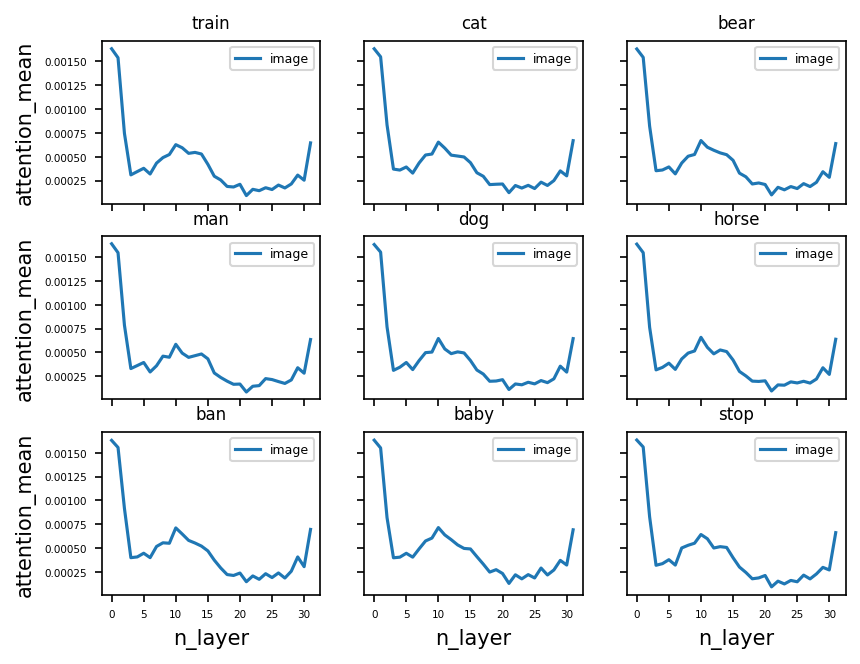

In [17]:
plot_data_attention(data_attention, class_images, label="image", xlabel='n_layer', ylabel='attention_mean')

Внимание в тексте

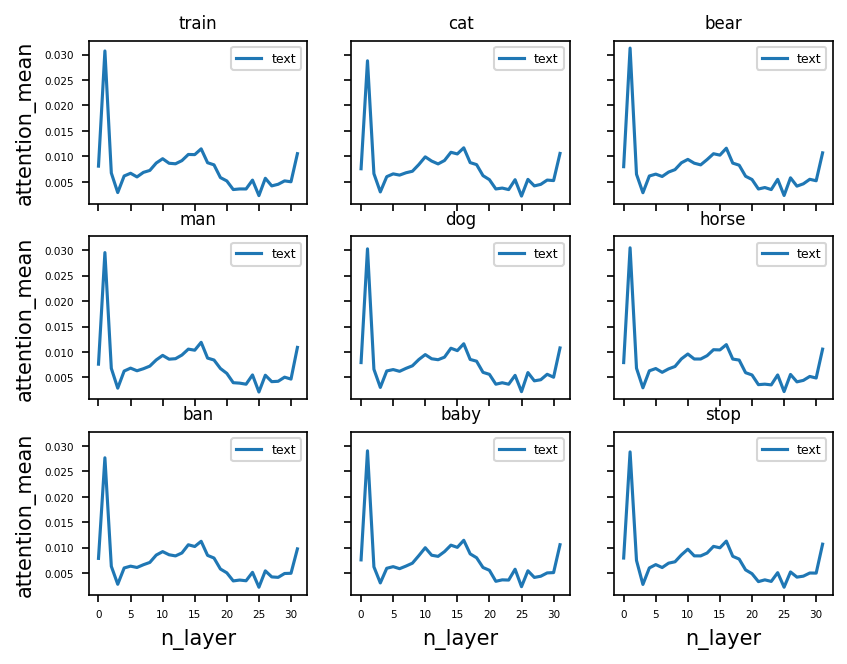

In [18]:
plot_data_attention(data_attention, class_images, label="text", xlabel='n_layer', ylabel='attention_mean')

Внимание между текстом и изображением

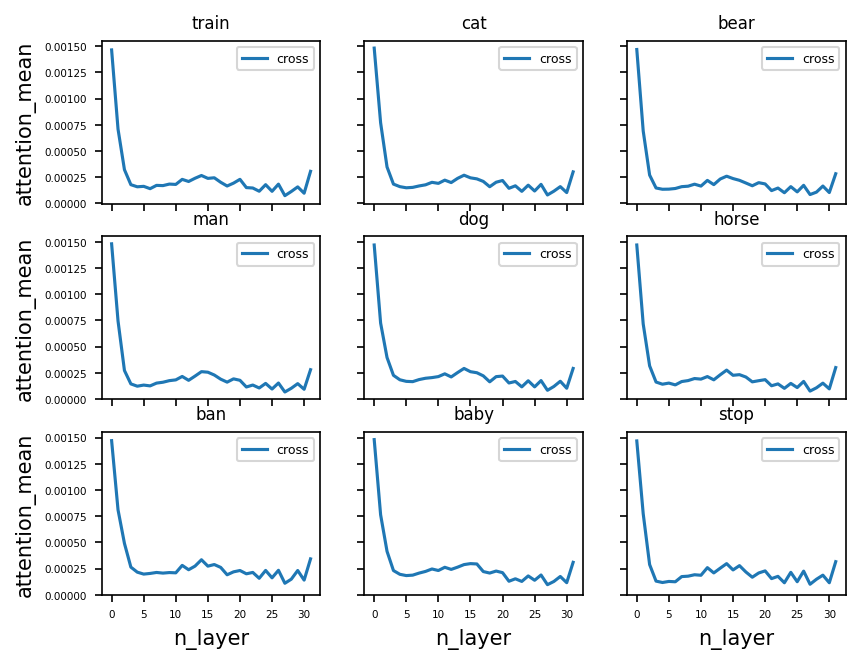

In [19]:
plot_data_attention(data_attention, class_images, label="cross", xlabel='n_layer', ylabel='attention_mean')